#Load Data

In [5]:
!unzip archive.zip -d archive

Archive:  archive.zip
  inflating: archive/the-reddit-dataset-dataset-comments.csv  
  inflating: archive/the-reddit-dataset-dataset-posts.csv  


In [6]:
import os
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

RANDOM_SEED = 4

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

import warnings
warnings.simplefilter('ignore')

print("Package import test successful!")

Package import test successful!


In [7]:
df_comments = pd.read_csv("/content/archive/the-reddit-dataset-dataset-comments.csv")
df_comments.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,body,sentiment,score
0,comment,hyyz6g8,2r97t,datasets,False,1646173750,https://old.reddit.com/r/datasets/comments/t45...,Spatial problem: Suitability of new locations ...,0.0772,1
1,comment,hyyid7v,2r97t,datasets,False,1646167280,https://old.reddit.com/r/datasets/comments/sg9...,Have you tried toying around with GDELT or Ali...,0.0000,2
2,comment,hyxp1qp,2r97t,datasets,False,1646156018,https://old.reddit.com/r/datasets/comments/t44...,Damn random internet person of whom I know not...,-0.3851,3
3,comment,hyxgnyu,2r97t,datasets,False,1646152782,https://old.reddit.com/r/datasets/comments/t44...,Ah nice one. Best of luck with the baby. If yo...,0.9136,3
4,comment,hyxfjw6,2r97t,datasets,False,1646152345,https://old.reddit.com/r/datasets/comments/t49...,I was about to write and say this shouldn't be...,0.0762,2


In [72]:
df_comments['subreddit.id'].unique()

array(['2r97t'], dtype=object)

In [8]:
df_posts = pd.read_csv("/content/archive/the-reddit-dataset-dataset-posts.csv")
df_posts.head()

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,t4f9bf,2r97t,datasets,False,1646160815,https://old.reddit.com/r/datasets/comments/t4f...,pravda.com.ua,NaN,[removed],[ Removed by Reddit ],7
1,post,t4euxw,2r97t,datasets,False,1646159793,https://old.reddit.com/r/datasets/comments/t4e...,self.datasets,NaN,Wanted to share this conference on Cloud Data ...,"Cool Cloud Data Lake conference by AWS, Dremio...",1
2,post,t4e0bb,2r97t,datasets,False,1646157650,https://old.reddit.com/r/datasets/comments/t4e...,self.datasets,NaN,[removed],Help scraping a store locator from a website?,1
3,post,t49fq0,2r97t,datasets,False,1646145753,https://old.reddit.com/r/datasets/comments/t49...,self.datasets,NaN,"Hi, I have a dataset with countries by 3 lette...",3 letter country code to full country name,1
4,post,t47wiw,2r97t,datasets,False,1646141275,https://old.reddit.com/r/datasets/comments/t47...,self.datasets,NaN,I want to classify if an image contains a cont...,Looking for datasets that contain images of co...,2


#Data Preparation (Document Construction)

In [20]:
df_comments["post_id"] = (
    df_comments["permalink"]
    .str.extract(r"/comments/([a-z0-9]+)/")
)

df_comments["text"] = df_comments["body"].fillna("")

comments_by_post = (
    df_comments
    .groupby("post_id")["text"]
    .apply(lambda x: "\n".join(x))
    .reset_index()
    .rename(columns={"text": "comments_text"})
)

df_documents = pd.merge(
    df_posts,
    comments_by_post,
    left_on="id",
    right_on="post_id",
    how="inner"
)

df_posts["text"] = (
    df_posts["title"].fillna("") + " " +
    df_posts["selftext"].fillna("")
)

df_documents["document"] = (
    df_documents["text"] + "\n" +
    df_documents["comments_text"].fillna("")
)


In [24]:
print(df_documents.shape)
print(df_documents["score"].describe())

(12787, 16)
count    12787.000000
mean        10.960741
std         23.380868
min          0.000000
25%          1.000000
50%          4.000000
75%         10.000000
max        849.000000
Name: score, dtype: float64


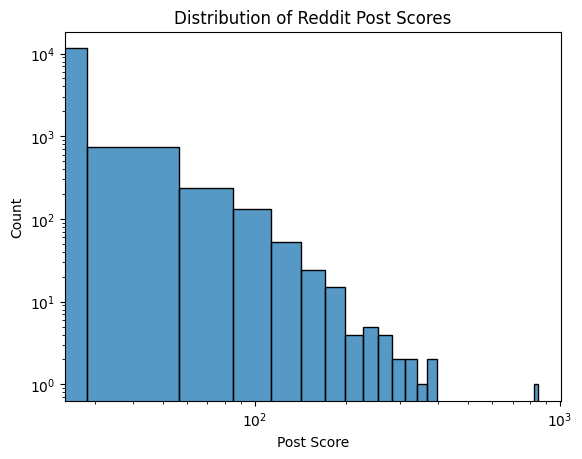

In [29]:
sns.histplot(df_documents["score"], bins=30)
plt.title("Distribution of Reddit Post Scores")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Post Score")
plt.ylabel("Count")
plt.show()

In [53]:
import re

def basic_english_clean(text):
    text = text.encode("ascii", errors="ignore").decode()

    text = re.sub(r"[^a-zA-Z\s]", " ", text)

    text = re.sub(r"\s+", " ", text).strip()

    return text.lower()

df_documents["document_clean"] = df_documents["document"].apply(basic_english_clean)
df_documents[["document", "document_clean"]].head()


,document,document_clean
0,"3 letter country code to full country name Hi,...",letter country code to full country name hi i ...
1,Looking for datasets that contain images of co...,looking for datasets that contain images of co...
2,[request] looking for a dataset that i can use...,request looking for a dataset that i can use t...
3,A datadump of more than 120 internal audits fr...,a datadump of more than internal audits from t...
4,Global Cities Elevation Database (Thank You) I...,global cities elevation database thank you i m...


In addition to stop-word removal, we can remove non-ASCII characters and non-alphabetic tokens to reduce noise from URLs, code fragments, and non-English text. This prevents rare foreign tokens from receiving disproportionately high TF-IDF weights.

#Exploratory Data Analysis (EDA) + Statistical Test

Do higher-scoring posts tend to have more text?

In [30]:
df_documents["doc_length"] = df_documents["document_clean"].apply(len)

In [54]:
median_score = df_documents["score"].median()

high_score_lengths = df_documents[df_documents["score"] > median_score]["doc_length"]
low_score_lengths = df_documents[df_documents["score"] <= median_score]["doc_length"]

print(f"Median score: {median_score}")

Median score: 4.0


In [55]:
t_stat, p_value = stats.ttest_ind(
    high_score_lengths,
    low_score_lengths,
    equal_var=False
)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("There IS a statistically significant difference in document length.")
else:
    print("There is NO statistically significant difference in document length.")

T-statistic: 20.62
P-value: 0.0000
There IS a statistically significant difference in document length.


Since Reddit scores are highly skewed, the geometric mean provides a more robust central tendency than the arithmetic mean and better reflects the typical post performance.

In [56]:
positive_scores = df_documents[df_documents["score"] > 0]["score"]

geo_mean_score = stats.gmean(positive_scores)

print(f"Geometric mean score: {geo_mean_score:.2f}")

high_score_mask = df_documents["score"] > geo_mean_score

def remove_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series[(series >= lower) & (series <= upper)]

high_score_lengths = remove_outliers_iqr(
    df_documents[high_score_mask]["doc_length"]
)

low_score_lengths = remove_outliers_iqr(
    df_documents[~high_score_mask]["doc_length"]
)

print(f"High-score docs after filtering: {len(high_score_lengths)}")
print(f"Low-score docs after filtering: {len(low_score_lengths)}")

t_stat, p_value = stats.ttest_ind(
    high_score_lengths,
    low_score_lengths,
    equal_var=False
)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("There IS a statistically significant difference in document length (outliers removed).")
else:
    print("There is NO statistically significant difference in document length (outliers removed).")

Geometric mean score: 4.81
High-score docs after filtering: 5260
Low-score docs after filtering: 6555
T-statistic: 33.63
P-value: 0.0000
There IS a statistically significant difference in document length (outliers removed).


In [57]:
def cohens_d(x, y):
    # Cohen’s d quantifies the magnitude of the difference independently of sample size.
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(
        ((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / (nx + ny - 2)
    )
    return (np.mean(x) - np.mean(y)) / pooled_std

print(f"Cohen's d: {cohens_d(high_score_lengths, low_score_lengths):.2f}")

Cohen's d: 0.66


After removing extreme outliers using an IQR-based filter and defining high-performing posts based on the geometric mean score, the t-test results indicate whether the difference in document length is robust to distributional skew. This analysis reduces the influence of unusually large discussion threads and provides a more conservative estimate of the effect.

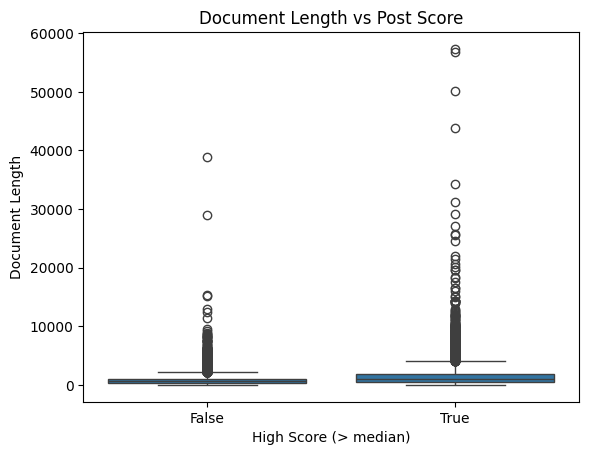

In [58]:
sns.boxplot(
    x=(df_documents["score"] > median_score),
    y=df_documents["doc_length"]
)
plt.xlabel("High Score (> median)")
plt.ylabel("Document Length")
plt.title("Document Length vs Post Score")
plt.show()

The distribution of document length is highly right-skewed with many extreme outliers, which compresses the interquartile range in a boxplot and makes group differences hard to visually assess.

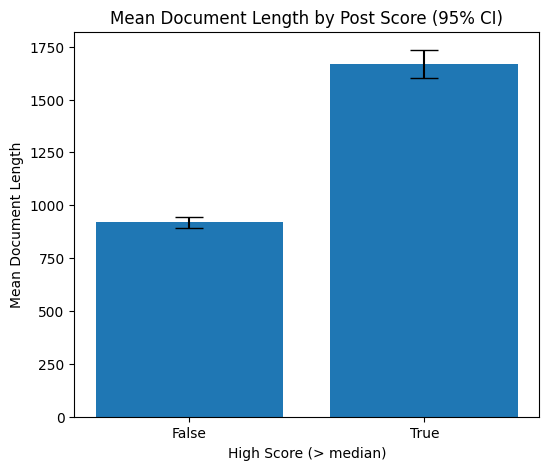

In [59]:
grouped = (
    df_documents
    .assign(high_score = df_documents["score"] > median_score)
    .groupby("high_score")["doc_length"]
    .agg(["mean", "count", "std"])
)

grouped["sem"] = grouped["std"] / np.sqrt(grouped["count"])
grouped["ci95"] = 1.96 * grouped["sem"]

plt.figure(figsize=(6, 5))

plt.bar(
    grouped.index.astype(str),
    grouped["mean"],
    yerr=grouped["ci95"],
    capsize=10
)

plt.xlabel("High Score (> median)")
plt.ylabel("Mean Document Length")
plt.title("Mean Document Length by Post Score (95% CI)")
plt.show()

The mean document length of high-scoring posts is higher than that of low-scoring posts. The 95% confidence intervals show limited overlap, suggesting that the difference is statistically meaningful. However, the distribution is highly skewed, indicating that a small number of very long discussions drive this effect.

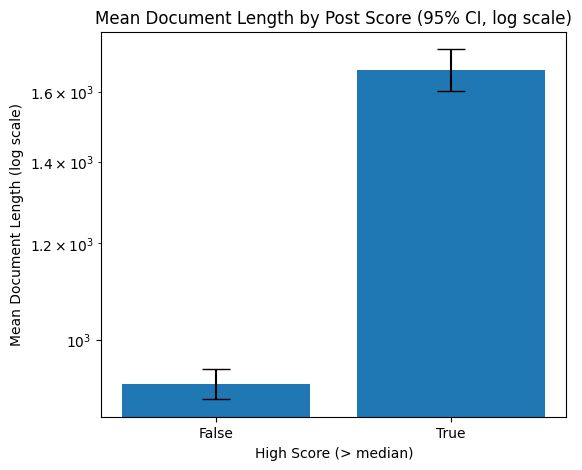

In [60]:
plt.figure(figsize=(6, 5))

plt.bar(
    grouped.index.astype(str),
    grouped["mean"],
    yerr=grouped["ci95"],
    capsize=10
)

plt.yscale("log")
plt.xlabel("High Score (> median)")
plt.ylabel("Mean Document Length (log scale)")
plt.title("Mean Document Length by Post Score (95% CI, log scale)")
plt.show()

#Text Representation: TF-IDF → SVD

In [61]:
vectorizer = TfidfVectorizer(
    max_features=500,
    stop_words="english"
)

X_tfidf = vectorizer.fit_transform(df_documents["document_clean"])

print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (12787, 500)


In [62]:
y = (df_documents["score"] > median_score).astype(int)

In [63]:
svd = TruncatedSVD(n_components=2, random_state=RANDOM_SEED)
X_svd = svd.fit_transform(X_tfidf)

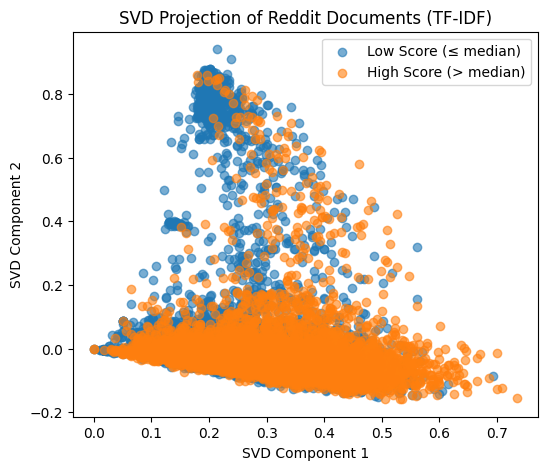

In [64]:
plt.figure(figsize=(6, 5))

scatter_low = plt.scatter(
    X_svd[y == 0, 0],
    X_svd[y == 0, 1],
    alpha=0.6,
    label="Low Score (≤ median)"
)

scatter_high = plt.scatter(
    X_svd[y == 1, 0],
    X_svd[y == 1, 1],
    alpha=0.6,
    label="High Score (> median)"
)

plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("SVD Projection of Reddit Documents (TF-IDF)")
plt.legend()
plt.show()

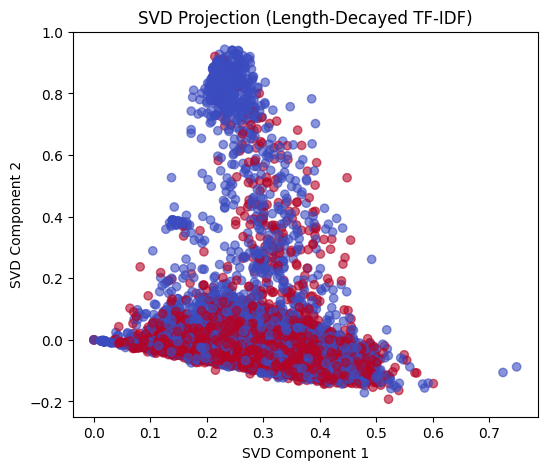

In [65]:
length_decay = 1 / np.log1p(df_documents["doc_length"])
length_decay = length_decay / length_decay.mean()
X_tfidf_decay = X_tfidf.multiply(length_decay.values[:, None])
X_svd_decay = svd.fit_transform(X_tfidf_decay)
plt.figure(figsize=(6, 5))
plt.scatter(
    X_svd_decay[:, 0],
    X_svd_decay[:, 1],
    c=y,
    cmap="coolwarm",
    alpha=0.6
)
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("SVD Projection (Length-Decayed TF-IDF)")
plt.show()

Each SVD component represents a latent combination of terms that captures a major source of variation in the corpus. The triangular structure reflects varying degrees of lexical diversity across documents, with most posts clustering around common vocabulary and fewer posts exhibiting more distinctive language.

The SVD projection shows substantial overlap between high- and low-scoring posts, indicating that lexical features alone are insufficient to fully separate the two groups. However, some regions of the projection are more densely populated by high-scoring posts, suggesting that language usage contains partial predictive information.

# Logistic Regression: Predicting High vs Low Score Posts

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

logreg = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_SEED
)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy (standard TF-IDF): {accuracy:.3f}")

Train shape: (10229, 500)
Test shape: (2558, 500)
Accuracy (standard TF-IDF): 0.659


The logistic regression model achieves an accuracy above the majority-class baseline, indicating that textual features contain predictive signal for post success.

In [67]:
weights = logreg.coef_[0]
terms = vectorizer.get_feature_names_out()

top_positive_idx = weights.argsort()[-10:][::-1]
top_negative_idx = weights.argsort()[:10]

top_positive_terms = [terms[i] for i in top_positive_idx]
top_negative_terms = [terms[i] for i in top_negative_idx]

print("Top terms associated with HIGH score posts:")
print(top_positive_terms)

print("\nTop terms associated with LOW score posts:")
print(top_negative_terms)


Top terms associated with HIGH score posts:
['awesome', 'great', 'cool', 'million', 'local', 'sharing', 'did', 'interesting', 'love', 'flair']

Top terms associated with LOW score posts:
['need', 'request', 'help', 'hello', 'hey', 'hd', 'looking', 'contact', 'trying', 'figure']


Positive coefficients indicate terms that increase the log-odds of a post being high-scoring, while negative coefficients are associated with lower-scoring posts.

In [68]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_tfidf_decay,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

logreg_decay = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_SEED
)

logreg_decay.fit(X_train_d, y_train_d)

y_pred_d = logreg_decay.predict(X_test_d)
accuracy_d = accuracy_score(y_test_d, y_pred_d)

print(f"Accuracy (length-decayed TF-IDF): {accuracy_d:.3f}")

print("Standard TF-IDF accuracy:", accuracy)
print("Length-decayed TF-IDF accuracy:", accuracy_d)

weights_d = logreg_decay.coef_[0]

top_positive_idx_d = weights_d.argsort()[-10:][::-1]
top_negative_idx_d = weights_d.argsort()[:10]

print("Top HIGH-score terms (decayed TF-IDF):")
print([terms[i] for i in top_positive_idx_d])

print("\nTop LOW-score terms (decayed TF-IDF):")
print([terms[i] for i in top_negative_idx_d])

baseline_accuracy = max(y.mean(), 1 - y.mean())
print(f"Majority-class baseline accuracy: {baseline_accuracy:.3f}")

Accuracy (length-decayed TF-IDF): 0.651
Standard TF-IDF accuracy: 0.6594996090695856
Length-decayed TF-IDF accuracy: 0.6505082095387021
Top HIGH-score terms (decayed TF-IDF):
['awesome', 'cool', 'local', 'great', 'million', 'sharing', 'did', 'flair', 'interesting', 'love']

Top LOW-score terms (decayed TF-IDF):
['need', 'request', 'hello', 'help', 'hey', 'hd', 'contact', 'looking', 'trying', 'mkv']
Majority-class baseline accuracy: 0.554


Aggressive downweighting may remove useful signal contained in longer discussions.

#Network Analysis

In [114]:
high_docs = df_documents[df_documents["score"] > geo_mean_score * 10]["document_clean"]
print(f"Number of high-score documents: {len(high_docs)}")

Number of high-score documents: 594


In [115]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def tokenize(text):
    return set(text.split())

STOPWORDS = set(ENGLISH_STOP_WORDS)

def tokenize_no_stopwords(text):
    return {
        word for word in text.split()
        if word not in STOPWORDS and len(word) > 2
    }

tfidf_vocab = set(vectorizer.get_feature_names_out())

def tokenize_tfidf_vocab(text):
    return {
        word for word in text.split()
        if word in tfidf_vocab
    }

In [116]:
WINDOW = 10
co_occurrence_window = defaultdict(int)

for doc in high_docs:
    tokens = list(tokenize_no_stopwords(doc))
    for i in range(len(tokens)):
        window_tokens = tokens[i+1:i+WINDOW]
        for w in window_tokens:
            if tokens[i] != w:
                co_occurrence_window[(tokens[i], w)] += 1

In [117]:
G = nx.Graph()

MIN_CO_OCCURRENCE = 20

for (w1, w2), count in co_occurrence_window.items():
    if count >= MIN_CO_OCCURRENCE:
        G.add_edge(w1, w2, weight=count)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 326
Number of edges: 920


Average degree: 5.64
Is network fully connected? False
Largest component size: 324
Percentage of nodes in largest component: 99.39%
Top 10 words by degree:
data: 63
https: 44
dataset: 44
thanks: 38
just: 34
use: 34
com: 28
www: 28
datasets: 27
think: 26

Top 10 words by weighted degree:
data: 2423
dataset: 1911
https: 1896
just: 1428
use: 1301
thanks: 1295
www: 1254
com: 1125
like: 933
think: 882


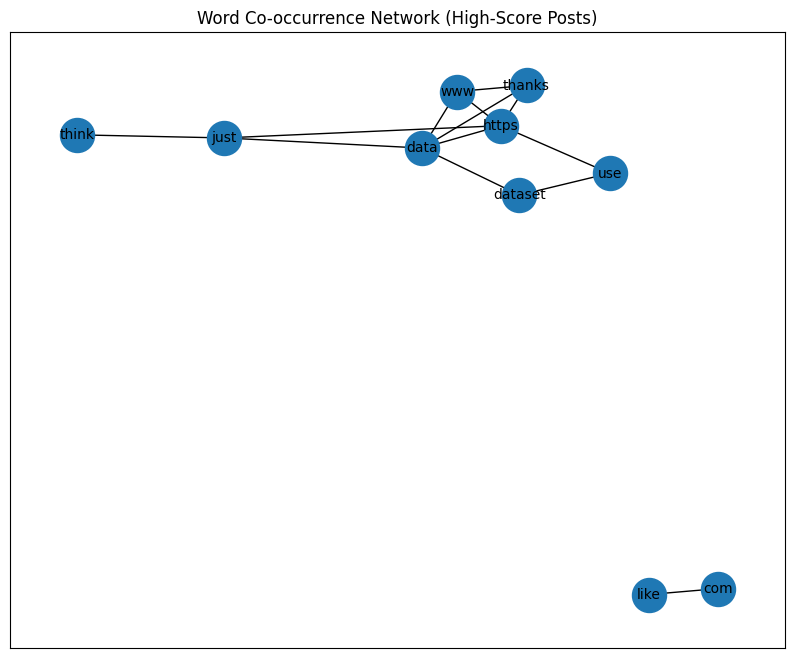

In [118]:
avg_degree = np.mean([d for _, d in G.degree()])
print(f"Average degree: {avg_degree:.2f}")

is_connected = nx.is_connected(G)
print(f"Is network fully connected? {is_connected}")

components = list(nx.connected_components(G))
largest_component = max(components, key=len)

print(f"Largest component size: {len(largest_component)}")
print(f"Percentage of nodes in largest component: {len(largest_component) / G.number_of_nodes() * 100:.2f}%")


top_degree_nodes = sorted(
    G.degree,
    key=lambda x: x[1],
    reverse=True
)[:10]

print("Top 10 words by degree:")
for word, deg in top_degree_nodes:
    print(f"{word}: {deg}")

weighted_degree = dict(G.degree(weight="weight"))

top_weighted = sorted(
    weighted_degree.items(),
    key=lambda x: x[1],
    reverse=True
)[:10]

print("\nTop 10 words by weighted degree:")
for word, wdeg in top_weighted:
    print(f"{word}: {wdeg}")

top_nodes = [node for node, _ in top_weighted[:20]]
subgraph = G.subgraph(top_nodes)

plt.figure(figsize=(10, 8))
nx.draw_networkx(
    subgraph,
    with_labels=True,
    node_size=600,
    font_size=10
)
plt.title("Word Co-occurrence Network (High-Score Posts)")
plt.show()

In [119]:
pagerank = nx.pagerank(G, weight="weight")

top_pagerank = sorted(
    pagerank.items(),
    key=lambda x: x[1],
    reverse=True
)[:10]

print("Top 10 words by PageRank:")
for word, score in top_pagerank:
    print(f"{word}: {score:.4f}")


Top 10 words by PageRank:
data: 0.0421
dataset: 0.0258
https: 0.0233
just: 0.0228
thanks: 0.0177
com: 0.0170
use: 0.0165
www: 0.0157
know: 0.0155
think: 0.0147


In [120]:
betweenness = nx.betweenness_centrality(G, weight="weight")

top_betweenness = sorted(
    betweenness.items(),
    key=lambda x: x[1],
    reverse=True
)[:10]

print("\nTop 10 bridge words (betweenness):")
for word, score in top_betweenness:
    print(f"{word}: {score:.4f}")


Top 10 bridge words (betweenness):
data: 0.3943
https: 0.1906
thanks: 0.1590
datasets: 0.1475
thank: 0.1363
just: 0.1123
dataset: 0.1022
time: 0.0997
deleted: 0.0762
think: 0.0725


# Post–Post Similarity Network (TF-IDF–based)

In [129]:
df_net = df_documents[df_documents["score"] > geo_mean_score * 10].reset_index(drop=True)
print(f"Number of posts in network: {len(df_net)}")

vectorizer_net = TfidfVectorizer(
    max_features=300,
    stop_words="english"
)

X_net = vectorizer_net.fit_transform(df_net["document_clean"])

from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(X_net)

print('Similarity matrix shape: ', similarity_matrix.shape)

SIM_THRESHOLD = 0.5

G_sim = nx.Graph()

for idx, post_id in enumerate(df_net["id"]):
    G_sim.add_node(idx, post_id=post_id)

for i in range(len(df_net)):
    for j in range(i + 1, len(df_net)):
        sim = similarity_matrix[i, j]
        if sim >= SIM_THRESHOLD:
            G_sim.add_edge(i, j, weight=sim)

print("Nodes:", G_sim.number_of_nodes())
print("Edges:", G_sim.number_of_edges())

print("Is connected:", nx.is_connected(G_sim))

components = list(nx.connected_components(G_sim))
largest_comp = max(components, key=len)

print("Largest component size:", len(largest_comp))
print(
    "Percentage in largest component:",
    len(largest_comp) / G_sim.number_of_nodes() * 100
)

top_degree = sorted(
    G_sim.degree,
    key=lambda x: x[1],
    reverse=True
)[:10]

print("Top posts by degree: ", top_degree)

weighted_degree = dict(G_sim.degree(weight="weight"))

top_weighted = sorted(
    weighted_degree.items(),
    key=lambda x: x[1],
    reverse=True
)[:10]

print("Top posts by weighted degree: ", top_weighted)

pagerank_sim = nx.pagerank(G_sim, weight="weight")

top_pagerank = sorted(
    pagerank_sim.items(),
    key=lambda x: x[1],
    reverse=True
)[:10]

print("Top posts by PageRank: ", top_pagerank)

betweenness_sim = nx.betweenness_centrality(G_sim, weight="weight")

top_betweenness = sorted(
    betweenness_sim.items(),
    key=lambda x: x[1],
    reverse=True
)[:10]

print("Top bridge posts: ", top_betweenness)

Number of posts in network: 594
Similarity matrix shape:  (594, 594)
Nodes: 594
Edges: 677
Is connected: False
Largest component size: 255
Percentage in largest component: 42.92929292929293
Top posts by degree:  [(293, 22), (55, 18), (143, 17), (177, 17), (452, 16), (500, 16), (197, 14), (230, 14), (258, 14), (269, 14)]
Top posts by weighted degree:  [(293, np.float64(13.206245704756325)), (367, np.float64(10.779938178056529)), (269, np.float64(10.61671483029361)), (143, np.float64(10.49672433167021)), (500, np.float64(10.054190458582323)), (458, np.float64(9.978080108928108)), (230, np.float64(9.951403585126338)), (452, np.float64(9.93348506984875)), (98, np.float64(9.820560503209679)), (55, np.float64(9.786594701947736))]
Top posts by PageRank:  [(293, 0.010628225782177337), (576, 0.009934352570719184), (55, 0.009625903931214229), (93, 0.008608591451834438), (177, 0.00810954793108928), (4, 0.007367131457333298), (376, 0.00663388973606455), (258, 0.0063062568443903915), (205, 0.006225

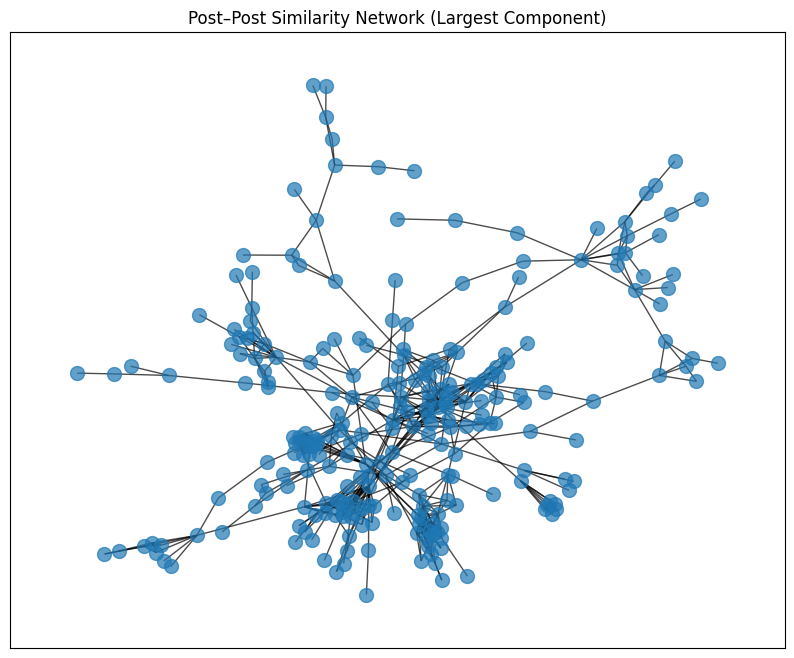

In [130]:
subgraph = G_sim.subgraph(largest_comp)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=RANDOM_SEED)

nx.draw_networkx(
    subgraph,
    pos,
    node_size=100,
    with_labels=False,
    alpha=0.7
)

plt.title("Post–Post Similarity Network (Largest Component)")
plt.show()

A post–post similarity network was constructed using cosine similarity of TF-IDF representations, with edges retained only above a similarity threshold to avoid a fully connected graph. The resulting network contains multiple connected components, enabling meaningful centrality analysis. PageRank highlights posts that are central within the semantic landscape, while betweenness centrality identifies posts that bridge otherwise distinct topical clusters.

In [132]:
def show_top_posts(node_list, df_net, top_k=5, text_chars=300):
    for i, (node_idx, metric_value) in enumerate(node_list[:top_k], 1):
        row = df_net.iloc[node_idx]

        print("=" * 80)
        print(f"Rank {i}")
        print(f"Network metric value: {metric_value}")
        print(f"Post ID: {row['id']}")
        print(f"Subreddit: {row['subreddit.name']}")
        print(f"Score: {row['score']}")
        print(f"Title: {row['title']}")
        print("\nPost content (excerpt):")
        print(row["document"][:text_chars])
        print()

In [133]:
show_top_posts(top_degree, df_net)

Rank 1
Network metric value: 22
Post ID: exnzrd
Subreddit: datasets
Score: 380
Title: Coronavirus Datasets

Post content (excerpt):
Coronavirus Datasets You have probably seen most of these, but I thought I'd share anyway:

**Spreadsheets and Datasets:**

* [https://www.worldometers.info/coronavirus/](https://www.worldometers.info/coronavirus/)
* [John Hopkins University Github](https://github.com/CSSEGISandData/2019-nCoV) confi

Rank 2
Network metric value: 18
Post ID: ml09ma
Subreddit: datasets
Score: 206
Title: New NBA dataset on Kaggle! - Every game 60,000+ (1946-2021) w/ box scores, line scores, series info, and more - every player 4500+ w/ draft data, career stats, biometrics, and more - and every team 30 w/ franchise histories, coaches/staffing, and more. Updated daily, with plans for expansion!

Post content (excerpt):
New NBA dataset on Kaggle! - Every game 60,000+ (1946-2021) w/ box scores, line scores, series info, and more - every player 4500+ w/ draft data, career stats, b

In [134]:
show_top_posts(top_weighted, df_net)

Rank 1
Network metric value: 13.206245704756325
Post ID: exnzrd
Subreddit: datasets
Score: 380
Title: Coronavirus Datasets

Post content (excerpt):
Coronavirus Datasets You have probably seen most of these, but I thought I'd share anyway:

**Spreadsheets and Datasets:**

* [https://www.worldometers.info/coronavirus/](https://www.worldometers.info/coronavirus/)
* [John Hopkins University Github](https://github.com/CSSEGISandData/2019-nCoV) confi

Rank 2
Network metric value: 10.779938178056529
Post ID: d4k68r
Subreddit: datasets
Score: 102
Title: 27,000 Games from Steam Store with SteamSpy data such as Owners and Playtime

Post content (excerpt):
27,000 Games from Steam Store with SteamSpy data such as Owners and Playtime Dataset on Kaggle:

[https://www.kaggle.com/nikdavis/steam-store-games](https://www.kaggle.com/nikdavis/steam-store-games)

Scraping, cleaning, and EDA on my personal blog (may help give you some ideas of how to use it):

[

Rank 3
Network metric value: 10.616714830293

In [135]:
show_top_posts(top_pagerank, df_net)

Rank 1
Network metric value: 0.010628225782177337
Post ID: exnzrd
Subreddit: datasets
Score: 380
Title: Coronavirus Datasets

Post content (excerpt):
Coronavirus Datasets You have probably seen most of these, but I thought I'd share anyway:

**Spreadsheets and Datasets:**

* [https://www.worldometers.info/coronavirus/](https://www.worldometers.info/coronavirus/)
* [John Hopkins University Github](https://github.com/CSSEGISandData/2019-nCoV) confi

Rank 2
Network metric value: 0.009934352570719184
Post ID: 3bxlg7
Subreddit: datasets
Score: 849
Title: I have every publicly available Reddit comment for research. ~ 1.7 billion comments @ 250 GB compressed. Any interest in this?

Post content (excerpt):
I have every publicly available Reddit comment for research. ~ 1.7 billion comments @ 250 GB compressed. Any interest in this? I am currently doing a massive analysis of Reddit's entire publicly available comment dataset.  The dataset is ~1.7 billion JSON objects complete with the comment, s

In [136]:
show_top_posts(top_betweenness, df_net)

Rank 1
Network metric value: 0.05739824985187548
Post ID: ml09ma
Subreddit: datasets
Score: 206
Title: New NBA dataset on Kaggle! - Every game 60,000+ (1946-2021) w/ box scores, line scores, series info, and more - every player 4500+ w/ draft data, career stats, biometrics, and more - and every team 30 w/ franchise histories, coaches/staffing, and more. Updated daily, with plans for expansion!

Post content (excerpt):
New NBA dataset on Kaggle! - Every game 60,000+ (1946-2021) w/ box scores, line scores, series info, and more - every player 4500+ w/ draft data, career stats, biometrics, and more - and every team 30 w/ franchise histories, coaches/staffing, and more. Updated daily, with plans for expansion! 
Hi, O

Rank 2
Network metric value: 0.036267717970922014
Post ID: exnzrd
Subreddit: datasets
Score: 380
Title: Coronavirus Datasets

Post content (excerpt):
Coronavirus Datasets You have probably seen most of these, but I thought I'd share anyway:

**Spreadsheets and Datasets:**

* 

Inspecting the content of high-centrality posts reveals that degree and PageRank identify broadly discussed dataset and tooling questions, while betweenness highlights posts that connect different types of discussions, such as data collection, preprocessing, and analysis methodology. While degree and PageRank highlight popular or central topics, betweenness centrality surfaces posts that connect otherwise distinct themes, emphasizing structural rather than popularity-based importance.